In [ ]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import time

from scipy import stats

import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.pipeline import Pipeline


# for classification
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# for regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


# Preprocessing of the data

In [9]:
# load and import the data

df_final = pd.read_csv('df_model.csv')

In [10]:
df_model = df_final.copy()

In [11]:
df_model.shape

(107765, 55)

In [12]:
def drop_columns(df):
    '''
    Drop columns from the dataframe

    Parameters
    ----------
    df : pandas dataframe
        The dataframe to drop columns from

        
    Returns
    -------
    df : pandas dataframe
        The dataframe with the columns dropped
    '''

    cols_to_drop = ['RFM_BUYER', 'ORDER_VALUE_RANGE','ID_CONDITION','ID_CATEGORY',
                   'ID_SUBCATEGORY','ID_BRAND', 'ID_PAYMENT_TYPE', 'ORDER_MARKETING_CHANNEL' , 
                   'Total_likes', 'Total_wishes', 'Total_MMAO_NB', 'Avg_commision_x' , 'Avg_commision_y']
    
    
    to_drop_maybe = ['NL_REACTIVITY_GROUP', 'NB_products_liked','NB_categories_liked', 'NB_products_commented', 'NB_categories_commented']

    df.drop(cols_to_drop, axis=1, inplace=True)

    return df

In [14]:
def date_time_converting(df):
    '''
    Convert the date columns to datetime and create new columns for the number of days 
    between the first order and the creation of the account

    Parameters
    ----------

    df : pandas dataframe
    The dataframe to convert the date columns to datetime and create new columns for the 
    number of days between the first order and the creation of the account

    Returns
    -------
    df : pandas dataframe
    The dataframe with the date columns converted to datetime and new columns for the

    '''
    # Convert the date columns to datetime
    df['DATE_CREATION'] = pd.to_datetime(df['DATE_CREATION'])
    df['DATE_FIRST_PURCHASE'] = pd.to_datetime(df['DATE_FIRST_PURCHASE'])
    df['DATE_LAST_LOGIN'] = pd.to_datetime(df['DATE_LAST_LOGIN'])
    df['DATE_LAST_PURCHASE'] = pd.to_datetime(df['DATE_LAST_PURCHASE'])

    # Create a new column for the number of days between the first order and the creation of the account
    df['days_bf_first_order'] = (df['DATE_FIRST_PURCHASE'] - df['DATE_CREATION']).dt.days

    # recency login compared to today
    df['days_since_last_login'] = (pd.to_datetime('2023/02/11') - df['DATE_LAST_LOGIN']).dt.days

    # recency order compared to today
    df['days_since_last_order'] = (pd.to_datetime('2023/02/11') - df['DATE_LAST_PURCHASE']).dt.days

    # Drop the date columns
    df.drop(['DATE_CREATION', 'DATE_NEW_BUYER', 'LastLikeDate', 'LastCommentDate', 
             'DATE_FIRST_PURCHASE', 'DATE_LAST_LOGIN', 'DATE_LAST_PURCHASE'], axis=1, inplace=True)
    df.drop(['Total_nb_likes', 'Total_nb_wish'], axis=1, inplace=True)

    return df

In [15]:
def missing_values(df):
    # Dealing with the missing values

    # Replacing the missing values with 0 
    df['NB_products_liked'].fillna(0, inplace=True)
    df['NB_categories_liked'].fillna(0, inplace=True)
    df['Frequnecy_like_12M'].fillna(0, inplace=True)
    df['NB_products_commented'].fillna(0, inplace=True)
    df['NB_categories_commented'].fillna(0, inplace=True)
    df['Frequnecy_comment_12M'].fillna(0, inplace=True)

    # Replacing the missing values with 999
    df['Recency_comment'].fillna(999, inplace=True)
    df['Recency_liked'].fillna(999, inplace=True)

    return df

In [16]:
def encoding(df):
    ### ecoding the categorical variables 

    ##ordinal encoding
    # USER_SEGMENT
    user_seg_map = {'Hibernating' :0, 'Inactive 6-12M': 1, 'Dormant 6M': 2, 'About to Sleep': 3, 'At High Risk':4, 'At Risk' :5, 'Need Attention':6, 'New Customer': 7, 'Potential Engaged':8, 'Engaged':9, 'Highly Engaged':10}
    df['USER_SEGMENT'] = df['USER_SEGMENT'].map(user_seg_map)

    #BUYER_SEGMENT 
    buyer_seg_map = {'Low potential one timers':0,'High potential one timers' : 1,'Low quality repeaters':2, 'High potential repeaters':3, 'Top buyers - only':4, 'Top buyers - low value': 5, 'Top buyers - high value':6, 'Top buyers - VVIC':7}
    # OR maybe map with levels 1 to 3 with one timers, repeaters and top buyers
    df['BUYER_SEGMENT'] = df['BUYER_SEGMENT'].map(buyer_seg_map)

    #drop the columns 


    return df

In [17]:
df = drop_columns(df_model)
df = date_time_converting(df_model)
df = missing_values(df_model)
df = encoding(df_model)

In [18]:
df.drop('NL_REACTIVITY_GROUP', axis=1, inplace=True)
df.drop('NB_PURCHASED', axis=1, inplace=True)
df.drop('RANK_BUYER', axis=1, inplace=True)
df.drop('BUYER_SEGMENT', axis=1, inplace=True)
df.drop('NB_SOLD', axis=1, inplace=True)

In [19]:
df.head()

,ID_BUYER,RANK_WITHIN_SEGMENT,ID_SEGMENT,ID_GENDER,INACTIVE,NB_PUBLISHED,ID_RFM_BUYER,USER_SEGMENT,REPEATER,CLTV,NB_OFFERS,AVG_OFFERS,NB_DAYS_ONLINE,DEPOSIT_PRICE,PRICE_SOLD_GMV,NB_ITEMS,DISCOUNT_AMOUNT_GMV,BUYER_FEE_GMV,MMAO_PRICE_DROP,VOUCHER_REVENUE,NB_products_liked,NB_categories_liked,Recency_liked,Frequnecy_like_12M,NB_products_commented,NB_categories_commented,Recency_comment,Frequnecy_comment_12M,days_bf_first_order,days_since_last_login,days_since_last_order
0,15347487,38,0,2,0,1,3.0,10,1.0,4011.086544,55.0,1.447368,61,505.853754,443.753592,1.0,12.464280,9.906643,18.370339,12.464280,185.0,5.0,9.0,188.0,2.0,1.0,204.0,406.0,163,33,149
1,17180639,61,0,2,0,1,5.0,4,0.0,684.884065,20.0,2.222222,198,247.010703,170.155022,3.0,7.751938,17.441860,39.033872,7.751938,44.0,5.0,68.0,46.0,0.0,0.0,999.0,0.0,20,63,217
2,13154196,18146,0,1,0,0,5.0,5,0.0,239.520964,136.0,1.700000,469,173.410970,79.840321,3.0,7.984032,0.000000,15.037268,7.984032,29.0,2.0,319.0,29.0,0.0,0.0,999.0,0.0,216,163,372
3,16618931,535,0,1,0,0,5.0,1,0.0,273.159145,0.0,0.000000,77,271.867612,273.159145,1.0,23.752969,0.000000,0.000000,23.752969,0.0,0.0,999.0,0.0,0.0,0.0,999.0,0.0,1,291,290
4,15612679,1,0,2,0,0,5.0,2,0.0,209.625000,0.0,0.000000,2,195.000000,209.625000,1.0,0.000000,17.730496,0.000000,0.000000,1.0,1.0,340.0,1.0,0.0,0.0,999.0,0.0,1,160,367


In [20]:
def outliers_removal(df, outlier_method:str=None):
    '''
    Remove the outliers from the dataframe

    Parameters
    ----------
    df : pandas dataframe
        The dataframe to remove the outliers from

    outlier_method : str
        The method to use to remove the outliers

    Returns
    -------
    df : pandas dataframe
        The dataframe with the outliers removed
    '''

    if outlier_method == 'IQR':
        # IQR method
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

    elif outlier_method == 'zscore':
        # Z-score method
        df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

    return df

In [21]:
df.shape

(107765, 31)

In [22]:
df = outliers_removal(df, outlier_method='zscore')

In [23]:
df.shape

(88298, 31)

In [ ]:
# keep only 10000 rows for the moment 
df = df.sample(n=10000, random_state=42)

# Make ID_BUYER the index of the dataframe
df.set_index('ID_BUYER', inplace=True)

df.shape

In [54]:
# To avoid Leakage, we need to drop further columns
df.drop(['RANK_WITHIN_SEGMENT', 'ID_SEGMENT', 'ID_RFM_BUYER'], axis=1, inplace=True)

In [55]:
# Preparing the data to be used in the model
# Split the data into X and y 
X = df.drop(['REPEATER', 'CLTV'], axis=1)
y_rep = df['REPEATER']
y_cltv = df['CLTV']

In [56]:
# print the shape of X and y

print(X.shape)
print(y_rep.shape)
print(y_cltv.shape)

(10000, 25)
(10000,)
(10000,)


In [57]:
def pre_processing(df, X_train, X_test, scaling:bool = False, scaler:str = None, outliers:bool = False, outliers_method:str = None):
    '''
    Preprocess the data to be used in the model

    Parameters
    ----------
    df : pandas dataframe
        The dataframe to preprocess

    X_train : pandas dataframe
        The train set

    X_test : pandas dataframe
        The test set

    Returns
    -------
    X_train : pandas dataframe
        The train set after preprocessing

    X_test : pandas dataframe
        The test set after preprocessing

    '''

    # Scaling the data
    if scaling:
        if scaler == 'MinMaxScaler':
            # MinMaxScaler
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
        elif scaler == 'StandardScaler':
            # StandardScaler
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
        else:
            print('Please choose a valid scaler')   
    
    return X_train, X_test

# Model 1 : Predicting the probability of a customer to be a Repeater

In [58]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_rep, test_size=0.2, random_state=42)

In [59]:
X_train, X_test = pre_processing(df, X_train, X_test, scaling=True, scaler='StandardScaler')

In [60]:
df.head()

,ID_GENDER,INACTIVE,NB_PUBLISHED,USER_SEGMENT,REPEATER,CLTV,NB_OFFERS,AVG_OFFERS,NB_DAYS_ONLINE,DEPOSIT_PRICE,PRICE_SOLD_GMV,NB_ITEMS,DISCOUNT_AMOUNT_GMV,BUYER_FEE_GMV,MMAO_PRICE_DROP,VOUCHER_REVENUE,NB_products_liked,NB_categories_liked,Recency_liked,Frequnecy_like_12M,NB_products_commented,NB_categories_commented,Recency_comment,Frequnecy_comment_12M,days_bf_first_order,days_since_last_login,days_since_last_order
ID_BUYER,,,,,,,,,,,,,,,,,,,,,,,,,,,
14318312,3,0,1,5,1.0,339.032400,4.0,2.000000,35,157.980434,119.516200,1.000000,6.610000,0.000000,10.962856,5.508333,23.0,3.0,256.0,23.0,0.0,0.0,999.0,0.0,136,122,337
17333377,2,0,0,5,0.0,931.133492,0.0,0.000000,83,269.622643,232.783373,2.500000,5.813954,4.360465,-8.362469,4.844961,4.0,1.0,162.0,4.0,0.0,0.0,999.0,0.0,4,98,191
18291728,2,0,0,10,1.0,2261.156481,174.0,1.380952,197,200.867809,161.511177,1.142857,2.892244,7.401692,26.415924,2.892244,1209.0,6.0,0.0,1219.0,3.0,1.0,29.0,6.0,7,28,30
12702247,3,0,0,1,1.0,901.776138,31.0,1.240000,85,220.793718,128.825163,1.285714,3.373250,0.000000,22.783770,2.811042,172.0,6.0,243.0,172.0,0.0,0.0,999.0,0.0,265,261,284
2237365,2,0,1,6,1.0,514.484600,33.0,2.357143,56,358.361775,257.242300,1.000000,17.301038,8.650519,85.570738,14.417532,91.0,6.0,44.0,33.0,0.0,0.0,999.0,0.0,2638,29,70


Testing different classification models

In [61]:
def classification_model_testing(df, X_train, X_test, y_train, y_test):
    '''

    Function that testes all the classification model imported into the notebook to have a global idea of the best model to use
    It should output a pandas dataframe called df_classification_result where each row represents the result of one model
    The columns should be the name of the model, the accuracy score, the precision score, the recall score and the f1 score

    Parameters
    ----------
    df : pandas dataframe
    The dataframe to use to train the model

    '''
    #set a seed for reproducibility
    np.random.seed(42)

    # Import the models

    models = {'Logistic Regression': LogisticRegression(), 'KNN': KNeighborsClassifier(), 'SVM': SVC(), 
              'Decision Tree': DecisionTreeClassifier(), 'Random Forest': RandomForestClassifier( n_jobs=-1),
              'Gradient Boosting': GradientBoostingClassifier(),
                'CatBoost': CatBoostClassifier(verbose=0)}
    
    df_classification_result = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

    for name, model in models.items():
        start = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        df_classification_result = df_classification_result.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1}, ignore_index=True)
        end = time.time()
        print(f'{name} has been fitted and evaluated')
        print(f'It took {end-start} seconds to fit and evaluate the model')
        print('--------------------------------------')

    df_classification_result = df_classification_result.sort_values(by='F1', ascending=False)

    return df_classification_result      

In [62]:
df_classification_result = classification_model_testing(df, X_train, X_test, y_train, y_test)

Logistic Regression has been fitted and evaluated
It took 0.05338001251220703 seconds to fit and evaluate the model
--------------------------------------
KNN has been fitted and evaluated
It took 0.3954586982727051 seconds to fit and evaluate the model
--------------------------------------
SVM has been fitted and evaluated
It took 3.9840452671051025 seconds to fit and evaluate the model
--------------------------------------
Decision Tree has been fitted and evaluated
It took 0.0942530632019043 seconds to fit and evaluate the model
--------------------------------------
Random Forest has been fitted and evaluated
It took 0.3747670650482178 seconds to fit and evaluate the model
--------------------------------------
Gradient Boosting has been fitted and evaluated
It took 2.029510021209717 seconds to fit and evaluate the model
--------------------------------------
CatBoost has been fitted and evaluated
It took 3.1683080196380615 seconds to fit and evaluate the model
------------------

In [63]:
df_classification_result

,Model,Accuracy,Precision,Recall,F1
6,CatBoost,0.7905,0.763889,0.783133,0.773391
5,Gradient Boosting,0.7915,0.773731,0.767798,0.770753
2,SVM,0.7640,0.762188,0.702081,0.730901
4,Random Forest,0.7585,0.748843,0.708653,0.728194
0,Logistic Regression,0.7375,0.738916,0.657174,0.695652
1,KNN,0.7230,0.700111,0.687842,0.693923
3,Decision Tree,0.7075,0.680220,0.677985,0.679100


Choice of best models, and hyperparameter tuning

# Model 2 : Predicting the Customer Lifetime Value (CLV) of a customer 

In [64]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_cltv, test_size=0.2, random_state=42)

In [65]:
X_train, X_test = pre_processing(df, X_train, X_test, scaling=True, scaler='StandardScaler')

In [66]:
def regression_model_testing(df, X_train, X_test, y_train, y_test):
    '''

    Function that testes all the regression model imported into the notebook to have a global idea of the best model to use
    It should output a pandas dataframe called df_regression_result where each row represents the result of one model
    The columns should be the name of the model, the mean absolute error, the mean squared error and the root mean squared error

    Parameters
    ----------
    df : pandas dataframe
    The dataframe to use to train the model

    '''
    #set a seed for reproducibility
    np.random.seed(42)

    # Import the models

    models = {'Linear Regression': LinearRegression(), 'Ridge Regression': Ridge(), 'Lasso Regression': Lasso(),
                'ElasticNet Regression': ElasticNet(), 'Decision Tree': DecisionTreeRegressor(), 'Random Forest': RandomForestRegressor( n_jobs=-1),
                'Gradient Boosting': GradientBoostingRegressor(), 'CatBoost': CatBoostRegressor(verbose=0)}
    
    df_regression_result = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])

    for name, model in models.items():
        start = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        df_regression_result = df_regression_result.append({'Model': name, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}, ignore_index=True)
        end = time.time()
        print(f'{name} has been fitted and evaluated')
        print(f'It took {end-start} seconds to fit and evaluate the model')
        print('--------------------------------------')

    
    df_regression_result = df_regression_result.sort_values(by='R2', ascending=False)

    return df_regression_result
        

In [67]:
df_regression_result = regression_model_testing(df, X_train, X_test, y_train, y_test)

Linear Regression has been fitted and evaluated
It took 0.010948657989501953 seconds to fit and evaluate the model
--------------------------------------
Ridge Regression has been fitted and evaluated
It took 0.00890493392944336 seconds to fit and evaluate the model
--------------------------------------
Lasso Regression has been fitted and evaluated
It took 0.0637807846069336 seconds to fit and evaluate the model
--------------------------------------
ElasticNet Regression has been fitted and evaluated
It took 0.006850004196166992 seconds to fit and evaluate the model
--------------------------------------
Decision Tree has been fitted and evaluated
It took 0.11353111267089844 seconds to fit and evaluate the model
--------------------------------------
Random Forest has been fitted and evaluated
It took 1.6789798736572266 seconds to fit and evaluate the model
--------------------------------------
Gradient Boosting has been fitted and evaluated
It took 2.05619478225708 seconds to fit 

In [68]:
df_regression_result

,Model,MAE,MSE,RMSE,R2
7,CatBoost,334.721385,4.719161e+05,686.961516,0.940505
5,Random Forest,367.352634,6.836370e+05,826.823431,0.913813
6,Gradient Boosting,524.452296,1.044475e+06,1021.995662,0.868321
4,Decision Tree,412.717631,2.244314e+06,1498.103445,0.717056
2,Lasso Regression,957.245878,4.388099e+06,2094.779062,0.446785
0,Linear Regression,958.588283,4.388464e+06,2094.866168,0.446739
1,Ridge Regression,958.539827,4.388511e+06,2094.877324,0.446733
3,ElasticNet Regression,957.228224,4.644047e+06,2155.005097,0.414517


In [34]:
def xgb_evaluation(df, outliers:bool= False):
    '''
    df : dataframe qui contient les données à analyser

    outliers: booléen qui permet de supprimer les outliers ou non
    -> outliers = True : on supprime les outliers
    -> outliers = False : on ne supprime pas les outliers
    
    Fonction qui permet d'effectuer une Grid Search sur les hyperparamètres du modèle XGBoost
    Ensuite, on évalue le modèle avec les meilleurs hyperparamètres

    return: y_pred : les prédictions du modèle, model : le modèle avec les meilleurs hyperparamètres

    '''
    # Grid Search
    # choix des hyperparamètres à tester pour le modèle XGBoost
    param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.1]
    }

    # cross validation avec 5 folds et mélange des données à chaque itération
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # création du modèle
    xgb_model = XGBRegressor(objective ='reg:squarederror', n_jobs=-1, tree_method='gpu_hist', random_state=42)

    start = time.time() # début du chronomètre

    # initialisation de la Grid Search avec les hyperparamètres à tester, le modèle et le nombre de folds
    grid_search = GridSearchCV(xgb_model, param_grid, cv=cv, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    print(grid_search.best_params_)
    print(grid_search.best_score_)

    end = time.time()

    print(f'Grid Search took {end - start} seconds')

    print('Grid Search fini !')

    print('---------')

    # Evaluation du modèle avec les meilleurs hyperparamètres

    
    xgtrain = xgb.DMatrix(X_train, label=y_train)
    xgtest = xgb.DMatrix(X_test, label=y_test)

    gbr =  xgb.XGBRegressor( objective ='reg:squarederror', n_jobs=-1, tree_method='gpu_hist', random_state=42, **grid_search.best_params_)

    model_test = xgb.train(gbr.get_xgb_params(), xgtrain, num_boost_round=1000, early_stopping_rounds=10, evals=[(xgtest, 'test')], verbose_eval=False)

    y_pred = model_test.predict(xgtest)

    print(f'MSE score: {mean_squared_error(y_test, y_pred)}')
    print(f'RMSE score: {np.sqrt(mean_squared_error(y_test, y_pred))}')
    print(f'MAE score: {mean_absolute_error(y_test, y_pred)}')
    print(f'R2 score: {r2_score(y_test, y_pred)}')

    print('Evaluation finie !')

    print('---------')

    # plot feature importance pour le modèle XGBoost

    xgb.plot_importance(model_test, max_num_features=10, importance_type='gain')
    plt.show()

    print('---------')

    # plot residual plot pour le modèle XGBoost

    plt.figure(figsize=(10, 10))
    sns.regplot(x=y_test, y=y_pred)
    plt.xlabel('Valeur réelle')
    plt.ylabel('Valeur prédite')

    if outliers: 
        plt.title(f'Régression du modèle XGBoost avec outliers, R2 = {np.round(r2_score(y_test, y_pred),4)} %')

    else:
        plt.title(f'Régression du modèle XGBoost, R2 = {np.round(r2_score(y_test, y_pred),4)} %')

    plt.show()

    print('-------')
    print('Fin de l\'évaluation du modèle XGBoost !') 

    return y_pred, model_test

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
0.9119398405815812
Grid Search took 176.56622910499573 seconds
Grid Search fini !
---------
MSE score: 538508.5601523101
RMSE score: 733.8314248874261
MAE score: 343.6697824901838
R2 score: 0.9452351357097674
Evaluation finie !
---------


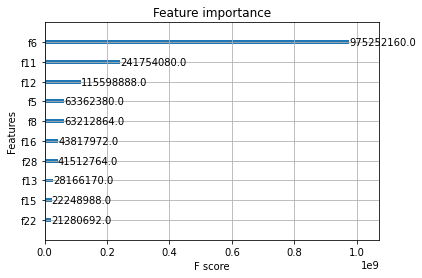

---------


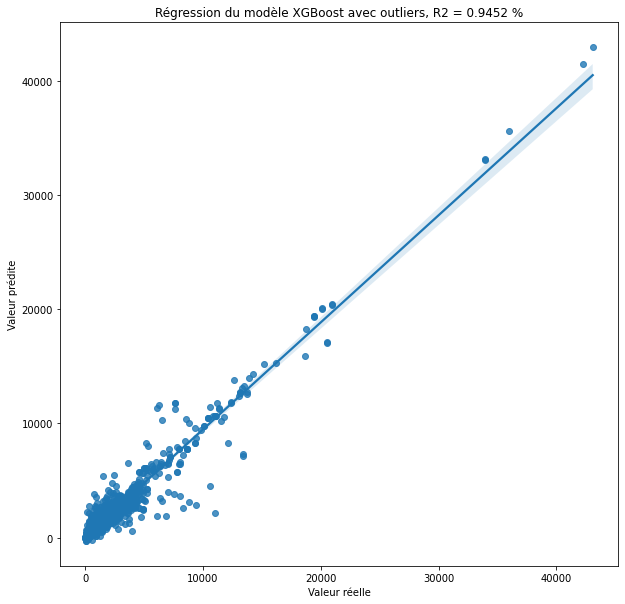

-------
Fin de l'évaluation du modèle XGBoost !


In [35]:
y_pred_xgb, model_test_xgb = xgb_evaluation(df, outliers=True)

In [ ]:
#""""""def random_forest_tuning():